<a href="https://colab.research.google.com/github/Karthikbv29/Batch108/blob/main/ModelBuilding_BackOrdersData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import the required modules

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc,recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
## For Grid Search
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
tf.__version__

'2.8.2'

#### Load the data

In [ ]:
data1=pd.read_csv("BackOrders.csv")
data1.head(3)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


In [ ]:
# Check data type of each attribute
data1.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [ ]:
for col in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data1[col] = data1[col].astype('category')

##### Display data type of each variable

In [ ]:
#Display data type of each variable
data1.dtypes

sku                     int64
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

In [ ]:
#### Delete sku attribute
np.size(np.unique(data1.sku, return_counts=True)[0])

61589

In [ ]:
data1.nunique()

sku                  61589
national_inv          2916
lead_time               28
in_transit_qty         908
forecast_3_month      1623
forecast_6_month      2195
forecast_9_month      2664
sales_1_month         1092
sales_3_month         1928
sales_6_month         2679
sales_9_month         3220
min_bank              1098
potential_issue          2
pieces_past_due        190
perf_6_month_avg       102
perf_12_month_avg      102
local_bo_qty           201
deck_risk                2
oe_constraint            2
ppap_risk                2
stop_auto_buy            2
rev_stop                 2
went_on_backorder        2
dtype: int64

In [ ]:
data1.drop('sku', axis=1, inplace=True)

In [ ]:
#### Missing value analysis and dropping the records with missing values
data1.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

In [ ]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data1 = data1.dropna(axis=0)

#### For neural networks we require the data to be in numeric form

In [ ]:
cat_attr= ['potential_issue', 'deck_risk', 'oe_constraint',
           'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']
num_attr=data1.columns.difference(cat_attr)
cat_attr.pop()

print(num_attr)

print("\n")
print(cat_attr)

Index(['forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'in_transit_qty', 'lead_time', 'local_bo_qty', 'min_bank',
       'national_inv', 'perf_12_month_avg', 'perf_6_month_avg',
       'pieces_past_due', 'sales_1_month', 'sales_3_month', 'sales_6_month',
       'sales_9_month'],
      dtype='object')


['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']


#### Data preprocessing for numeric and categorical using pipelines

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
numeric_transformer = Pipeline(steps=[
                                      ('scale',StandardScaler()) ])

categorical_transformer = Pipeline(steps=[
                                         ('ohe',OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',numeric_transformer,num_attr) ,
                                              ('cat',categorical_transformer,cat_attr)])

In [ ]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scale', StandardScaler())]),
                                 Index(['forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'in_transit_qty', 'lead_time', 'local_bo_qty', 'min_bank',
       'national_inv', 'perf_12_month_avg', 'perf_6_month_avg',
       'pieces_past_due', 'sales_1_month', 'sales_3_month', 'sales_6_month',
       'sales_9_month'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['potential_issue', 'deck_risk',
                                  'oe_constraint', 'ppap_risk', 'stop_auto_buy',
                                  'rev_stop'])])

In [ ]:
#Performing train test split on the data
X, y = data1.loc[:,data1.columns!='went_on_backorder'], data1.loc[:,'went_on_backorder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [ ]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.fit_transform(X_test)

In [ ]:
y_test=y_test.replace({'Yes':1,'No':0})
y_train=y_train.replace({'Yes':1,'No':0})

In [ ]:
## Convert to numeric
y_train=y_train.values
y_test=y_test.values

In [ ]:
y_train

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
train=X_train
test=X_test

In [ ]:
print(train.shape)

print(test.shape)


(40730, 27)
(17456, 27)


### Perceptron Model (MLP) 

In [ ]:
perceptron_model = Sequential()
perceptron_model.add(Dense(1, input_dim=27, activation='tanh'))
perceptron_model.add(Dense(1, activation='sigmoid'))

In [ ]:
perceptron_model.compile(loss='binary_crossentropy', 
                         optimizer='sgd', 
                         metrics=['accuracy'])

In [ ]:
perceptron_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 28        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 2         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [ ]:
perceptron_model_history = perceptron_model.fit(train, 
                                                y_train, 
                                                epochs=50, 
                                                batch_size=32, 
                                                validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/50
32584/32584 [==============================] - 2s 58us/sample - loss: 0.5306 - acc: 0.7952 - val_loss: 0.4862 - val_acc: 0.8110
Epoch 2/50
32584/32584 [==============================] - 2s 56us/sample - loss: 0.4829 - acc: 0.8121 - val_loss: 0.4831 - val_acc: 0.8110
Epoch 3/50
32584/32584 [==============================] - 2s 50us/sample - loss: 0.4818 - acc: 0.8121 - val_loss: 0.4825 - val_acc: 0.8110
Epoch 4/50
32584/32584 [==============================] - 2s 52us/sample - loss: 0.4812 - acc: 0.8121 - val_loss: 0.4818 - val_acc: 0.8110
Epoch 5/50
32584/32584 [==============================] - 2s 49us/sample - loss: 0.4806 - acc: 0.8121 - val_loss: 0.4810 - val_acc: 0.8110
Epoch 6/50
32584/32584 [==============================] - 2s 49us/sample - loss: 0.4798 - acc: 0.8121 - val_loss: 0.4802 - val_acc: 0.8110
Epoch 7/50
32584/32584 [==============================] - 2s 51us/sample - loss: 0.4789 - acc: 0.8121 - val_loss: 0.4

In [ ]:
# lets write a function to get the metrics & loss plots

def plot(model_history, plot_type):
    val_type = "val_"+plot_type
    plt.plot(model_history.history[plot_type])
    plt.plot(model_history.history[val_type])
    plt.title('Accuracy Plot')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [ ]:
perceptron_model

In [ ]:
print(perceptron_model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


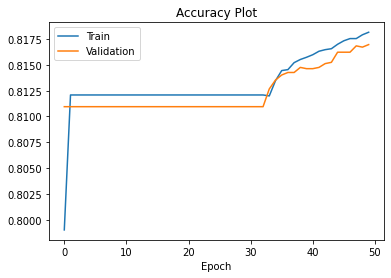

In [ ]:
plot(perceptron_model_history, 'accuracy')

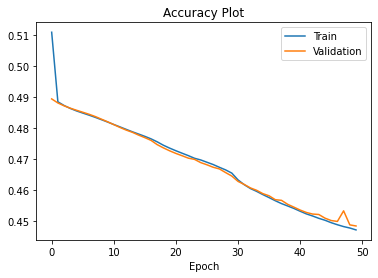

In [ ]:
plot(perceptron_model_history, 'loss')

In [ ]:
test_pred=(perceptron_model.predict(test) > 0.5).astype("int32")
train_pred=(perceptron_model.predict(train) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_train, train_pred)

array([[32787,   280],
       [ 7135,   528]])

In [ ]:
confusion_matrix(y_test, test_pred)

array([[14059,    91],
       [ 3103,   203]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(203, 3103, 91, 14059)

### Perceptron Model (MLP with 2 Neuron in Hidden Layer)

In [ ]:
mlp_model = Sequential()
mlp_model.add(Dense(2, input_dim=27, activation='tanh'))
mlp_model.add(Dense(1, activation='sigmoid'))

In [ ]:
mlp_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
x=mlp_model.fit(train, y_train, epochs=50, batch_size=32,validation_split=0.2)

Epoch 1/50
1019/1019 [==============================] - 2s 1ms/step - loss: 0.4933 - accuracy: 0.7999 - val_loss: 0.4826 - val_accuracy: 0.8073
Epoch 2/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4809 - accuracy: 0.8087 - val_loss: 0.4800 - val_accuracy: 0.8090
Epoch 3/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4779 - accuracy: 0.8104 - val_loss: 0.4771 - val_accuracy: 0.8101
Epoch 4/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4751 - accuracy: 0.8116 - val_loss: 0.4739 - val_accuracy: 0.8117
Epoch 5/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4728 - accuracy: 0.8121 - val_loss: 0.4717 - val_accuracy: 0.8121
Epoch 6/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4708 - accuracy: 0.8126 - val_loss: 0.4700 - val_accuracy: 0.8123
Epoch 7/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4690 - accuracy: 0.8129 - val_loss: 0.4685 - val_accuracy:

In [ ]:
print(pd.DataFrame(x.history))
print(x.history.keys())

        loss  accuracy  val_loss  val_accuracy
0   0.493329  0.799871  0.482631      0.807267
1   0.480897  0.808710  0.479971      0.808986
2   0.477877  0.810398  0.477070      0.810091
3   0.475123  0.811595  0.473859      0.811687
4   0.472750  0.812116  0.471712      0.812055
5   0.470838  0.812638  0.470013      0.812301
6   0.469028  0.812945  0.468514      0.812423
7   0.467462  0.813497  0.467141      0.812669
8   0.466065  0.813712  0.465867      0.813037
9   0.464816  0.814111  0.464781      0.813037
10  0.463520  0.814541  0.464032      0.813405
11  0.462389  0.814878  0.462680      0.814019
12  0.461217  0.815185  0.461920      0.814142
13  0.460154  0.815124  0.460382      0.814265
14  0.459081  0.815369  0.459585      0.814387
15  0.458114  0.815431  0.458499      0.814265
16  0.457195  0.815676  0.457626      0.814142
17  0.456367  0.815646  0.456764      0.814265
18  0.455534  0.815707  0.455891      0.814633
19  0.454732  0.816106  0.455516      0.814756
20  0.453949 

In [ ]:
mlp_model

In [ ]:
print(x.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


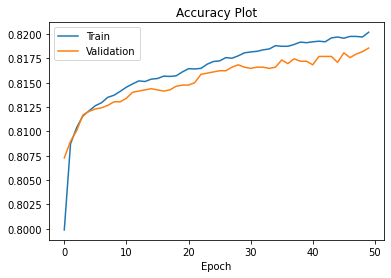

In [ ]:
plot(x, 'accuracy')

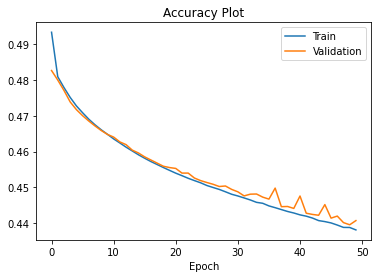

In [ ]:
plot(x, 'loss')

#### Predictions

In [ ]:
test_pred=(mlp_model.predict(test) > 0.5).astype("int32")
train_pred=(mlp_model.predict(train) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_train, train_pred)

array([[32672,   395],
       [ 6937,   726]])

In [ ]:
confusion_matrix(y_test, test_pred)

array([[13954,   196],
       [ 2946,   360]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(360, 2946, 196, 13954)

### Perceptron Model (MLP with 1 Neuron in Hidden Layer)

In [ ]:
mlp_model1 = Sequential()
mlp_model1.add(Dense(16, input_dim=27, activation='tanh'))
mlp_model1.add(Dense(1, activation='sigmoid'))

In [ ]:
mlp_model1.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
x=mlp_model1.fit(train, y_train, epochs=50, batch_size=32,validation_split=0.2)

Epoch 1/50
1019/1019 [==============================] - 2s 2ms/step - loss: 0.4881 - accuracy: 0.8004 - val_loss: 0.4730 - val_accuracy: 0.8111
Epoch 2/50
1019/1019 [==============================] - 2s 1ms/step - loss: 0.4701 - accuracy: 0.8121 - val_loss: 0.4695 - val_accuracy: 0.8117
Epoch 3/50
1019/1019 [==============================] - 2s 2ms/step - loss: 0.4671 - accuracy: 0.8125 - val_loss: 0.4666 - val_accuracy: 0.8119
Epoch 4/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4652 - accuracy: 0.8128 - val_loss: 0.4648 - val_accuracy: 0.8123
Epoch 5/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4636 - accuracy: 0.8133 - val_loss: 0.4630 - val_accuracy: 0.8130
Epoch 6/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4623 - accuracy: 0.8141 - val_loss: 0.4619 - val_accuracy: 0.8135
Epoch 7/50
1019/1019 [==============================] - 1s 1ms/step - loss: 0.4611 - accuracy: 0.8147 - val_loss: 0.4609 - val_accuracy:

In [ ]:
print(pd.DataFrame(x.history))
print(x.history.keys())

        loss  accuracy  val_loss  val_accuracy
0   0.488149  0.800424  0.473001      0.811073
1   0.470134  0.812116  0.469518      0.811687
2   0.467139  0.812515  0.466599      0.811932
3   0.465213  0.812792  0.464769      0.812301
4   0.463552  0.813344  0.463044      0.813037
5   0.462340  0.814142  0.461902      0.813528
6   0.461139  0.814664  0.460948      0.813896
7   0.460037  0.814909  0.459775      0.814265
8   0.459070  0.815063  0.458967      0.814142
9   0.458083  0.815277  0.458056      0.814265
10  0.457246  0.815277  0.457469      0.814387
11  0.456279  0.815584  0.456961      0.814387
12  0.455274  0.815768  0.455627      0.814510
13  0.454662  0.815799  0.454718      0.814878
14  0.453683  0.815891  0.457621      0.814633
15  0.453192  0.815983  0.453586      0.815001
16  0.452446  0.816014  0.452771      0.815247
17  0.451616  0.816658  0.452521      0.815124
18  0.451032  0.816843  0.451603      0.815615
19  0.450441  0.816812  0.451195      0.815861
20  0.449561 

In [ ]:
mlp_model1

In [ ]:
print(x.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


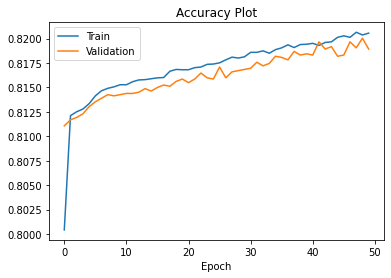

In [ ]:
plot(x, 'accuracy')

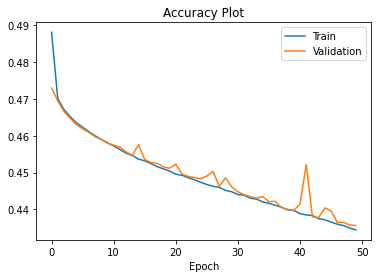

In [ ]:
plot(x, 'loss')

#### Predictions

In [ ]:
test_pred=(mlp_model1.predict(test) > 0.5).astype("int32")
train_pred=(mlp_model1.predict(train) > 0.5).astype("int32")

In [ ]:
confusion_matrix(y_train, train_pred)

array([[32846,   221],
       [ 7108,   555]])

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, test_pred,labels=[1,0]).reshape(-1)
(tn, fp, fn, tp)

(308, 2998, 113, 14037)